In [109]:
import json
import sys
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from s4hci.utils.data_handling import load_adi_data, save_as_fits
from s4hci.models.noise import S4Noise
from s4hci.utils.logging import print_message, setup_logger

from applefy.utils.fake_planets import add_fake_planets

In [110]:
from pathlib import Path
from copy import deepcopy
from datetime import datetime

import numpy as np
from scipy.stats import iqr
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

import torch
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

from s4hci.models.noise import S4Noise
from s4hci.models.planet import S4Planet
from s4hci.utils.adi_tools import combine_residual_stack
from s4hci.utils.data_handling import save_as_fits


class S4:

    def __init__(
            self,
            data_cube,
            parang,
            psf_template,
            noise_noise_cut_radius_psf,
            noise_mask_radius,
            device=0,
            noise_normalization="normal",
            noise_lambda_init=1e3,
            planet_convolve_second=True,
            planet_use_up_sample=1,
            work_dir=None,
            convolve=True,
            verbose=True
    ):
        # 1.) Save all member data
        self.device = device
        self.parang = parang
        self.data_cube = data_cube
        self.psf_template = psf_template
        self.data_image_size = data_cube.shape[-1]
        if work_dir is not None:
            self.work_dir = Path(work_dir)
        else:
            self.work_dir = None
        self.residuals_dir, self.tensorboard_dir, self.models_dir = \
            self._setup_working_dir()

        # 2.) Create the noise model
        self.noise_model = S4Noise(
            data_image_size=self.data_image_size,
            psf_template=self.psf_template,
            lambda_reg=noise_lambda_init,
            cut_radius_psf=noise_noise_cut_radius_psf,
            mask_template_setup=("radius", noise_mask_radius),
            normalization=noise_normalization,
            convolve=convolve,
            verbose=verbose).float()

        # 3.) Create the planet model
        self.planet_model = S4Planet(
            data_image_size=self.data_image_size,
            psf_template=self.psf_template,
            convolve_second=planet_convolve_second,
            inner_mask_radius=0,
            use_up_sample=planet_use_up_sample).float()

        # 4.) Create the tensorboard logger for the fine_tuning
        self.tensorboard_logger = None
        self.fine_tune_start_time = None

    def _setup_working_dir(self):
        if self.work_dir is None:
            return None, None, None

        # make sure the working dir is a dir
        self.work_dir.mkdir(exist_ok=True)

        residuals_dir = self.work_dir / "residuals"
        tensorboard_dir = self.work_dir / "tensorboard"
        models_dir = self.work_dir / "models"

        residuals_dir.mkdir(exist_ok=True)
        tensorboard_dir.mkdir(exist_ok=True)
        models_dir.mkdir(exist_ok=True)

        return residuals_dir, tensorboard_dir, models_dir

    def validate_lambdas_noise(
            self,
            num_separations,
            lambdas,
            num_test_positions,
            test_size=0.3,
            approx_svd=5000):
        """
        First processing step
        """

        # 1.) split the data into training and test data
        if isinstance(test_size, float):
            x_train, x_test, = train_test_split(
                self.data_cube,
                test_size=test_size,
                random_state=42,
                shuffle=True)
        else:
            # Use an even/odd split
            x_train = self.data_cube[0::2]
            x_test = self.data_cube[1::2]

        # 2.) validate the lambda values of the noise model
        x_train = torch.from_numpy(x_train).float()
        x_test = torch.from_numpy(x_test).float()

        all_results, best_lambda = self.noise_model.validate_lambdas(
            num_separations=num_separations,
            lambdas=lambdas,
            science_data_train=x_train,
            science_data_test=x_test,
            num_test_positions=num_test_positions,
            approx_svd=approx_svd,
            device=self.device)

        return all_results, best_lambda

    def find_closed_form_noise_model(
            self,
            save_model=False,
            fp_precision="float32",
            lstrq_mode="LSTSQ"):
        """
        Second processing step
        """

        # 1.) Train the noise model
        x_train = torch.from_numpy(self.data_cube).float()
        self.noise_model.fit(
            x_train,
            device=self.device,
            mode=lstrq_mode,
            fp_precision=fp_precision)

        # 2.) Save the noise model
        if save_model:
            self.noise_model.save(
                self.models_dir / "noise_model_closed_form.pkl")

    def _logg_fine_tune_status(
            self,
            epoch,
            loss_reg,
            start_reg_loss,
            loss_recon,
            start_recon_loss,
            logging_interval,
            planet_signal):

        if self.work_dir is None:
            return

        self.tensorboard_logger.add_scalar(
            "Loss/Reconstruction_delta",
            loss_recon - start_recon_loss,
            epoch)

        self.tensorboard_logger.add_scalar(
            "Loss/Regularization_delta",
            loss_reg - start_reg_loss,
            epoch)

        if not epoch % logging_interval == logging_interval - 1:
            return

        with torch.no_grad():
            tmp_frame = planet_signal.detach()[-1, 0].cpu().numpy()
            self.tensorboard_logger.add_image(
                "Images/Planet_signal_estimate",
                self.normalize_for_tensorboard(tmp_frame),
                epoch,
                dataformats="HW")

            tmp_residual_dir = self.residuals_dir / \
                Path(self.fine_tune_start_time)
            tmp_residual_dir.mkdir(exist_ok=True)

            save_as_fits(
                tmp_frame,
                tmp_residual_dir /
                Path("Planet_signal_estimate_epoch_" + str(epoch).zfill(4)
                     + ".fits"),
                overwrite=True)

            tmp_frame = self.planet_model.get_planet_signal()
            tmp_frame = tmp_frame.detach()[0].cpu().numpy()
            self.tensorboard_logger.add_image(
                "Images/Planet_raw_parameters",
                self.normalize_for_tensorboard(tmp_frame),
                epoch,
                dataformats="HW")

            save_as_fits(
                tmp_frame,
                tmp_residual_dir /
                Path("Planet_raw_parameters_" + str(epoch).zfill(4)
                     + ".fits"),
                overwrite=True)

            self.noise_model.compute_betas()
            betas = self.noise_model.prev_betas.detach().cpu().numpy()
            beta_frame = np.abs(betas[6500].reshape(
                self.data_image_size, self.data_image_size))

            self.tensorboard_logger.add_image(
                "Images/Noise_model_reasons",
                self.normalize_for_tensorboard(beta_frame),
                epoch,
                dataformats="HW")

    def fine_tune_model(
            self,
            num_epochs,
            learning_rate_planet=1e-3,
            learning_rate_noise=1e-6,
            fine_tune_noise_model=False,
            lean_planet_model=True,
            rotation_grid_down_sample=10,
            upload_rotation_grid=True,
            logging_interval=10,
            save_model=False,
            batch_size=-1
    ):
        """
        This is the last step of optimization
        """

        # 1.) setup planet model for training
        self.planet_model.setup_for_training(
            all_angles=self.parang,
            rotation_grid_down_sample=rotation_grid_down_sample,
            upload_rotation_grid=upload_rotation_grid)

        if self.work_dir is not None:
            time_str = datetime.now().strftime("%Y-%m-%d-%Hh%Mm%Ss")
            self.fine_tune_start_time = time_str
            current_logdir = self.tensorboard_dir /\
                Path(self.fine_tune_start_time)
            current_logdir.mkdir()
            self.tensorboard_logger = SummaryWriter(current_logdir)

        # 2.) move models to the GPU
        self.planet_model = self.planet_model.to(self.device)
        self.noise_model = self.noise_model.to(self.device)

        # 3.) set up the normalization
        # TODO update this code in case the robust normalization works
        x_train = torch.from_numpy(self.data_cube).float()
        x_mu = torch.mean(x_train, axis=0)
        x_std = torch.std(x_train, axis=0)
        x_norm = (x_train - x_mu) / x_std

        # move the data to the GPU
        x_std = x_std.to(self.device)
        x_norm = x_norm.to(self.device)
        science_norm_flatten = x_norm.view(x_norm.shape[0], -1)

        # 4.) Create the optimizer and add the parameters we want to optimize
        parameters = []
        if fine_tune_noise_model:
            parameters.append(
                {"params": self.noise_model.betas_raw,
                 'lr': learning_rate_noise})
        else:
            self.noise_model.betas_raw.requires_grad = False

        if lean_planet_model:
            parameters.append(
                {"params": self.planet_model.planet_model,
                 'lr': learning_rate_planet}
            )
        else:
            self.planet_model.planet_model.requires_grad = False

        # The default learning rate is not needed
        optimizer = optim.Adam(
            parameters,
            lr=learning_rate_planet)

        # if the noise model is not fine-tuned we can compute the noise estimate
        # once at the start of the training loop
        if not fine_tune_noise_model:
            pre_build_noise_noise_estimate = self.noise_model(
                science_norm_flatten.to(self.device))
        else:
            pre_build_noise_noise_estimate = torch.ones(
                science_norm_flatten.shape[0])

        # The index list is needed to get all planet frames during fine-tuning.
        planet_model_idx = torch.from_numpy(np.arange(x_norm.shape[0]))

        # 5.) Run the fine-tuning
        if self.noise_model.verbose:
            epoch_range = tqdm(range(num_epochs))
        else:
            epoch_range = range(num_epochs)

        # create the DataLoader
        merged_dataset = TensorDataset(
            science_norm_flatten,
            pre_build_noise_noise_estimate,
            planet_model_idx)

        if batch_size == -1:
            bs = x_norm.shape[0]
        else:
            bs = batch_size
        data_loader = DataLoader(
            merged_dataset,
            batch_size=bs,
            shuffle=True)

        # needed for gradient accumulation in order to normalize the loss
        num_steps_per_epoch = len(data_loader)

        # values needed to plot the difference in loss
        start_reg_loss = 0.
        start_recon_loss = 0.

        for epoch in epoch_range:
            optimizer.zero_grad()

            # we have to keep track of the loss sum within gradient accumulation
            running_reg_loss = 0
            running_recon_loss = 0

            for tmp_frames, noise_estimate, tmp_planet_idx in data_loader:
                # 1.) Get the current planet signal estimate
                planet_signal = self.planet_model.forward(tmp_planet_idx)

                # 2.) normalize and reshape the planet signal
                planet_signal = planet_signal / x_std
                planet_signal_norm = planet_signal.view(
                    planet_signal.shape[0], -1)

                # 3.) run the forward path
                if fine_tune_noise_model:
                    self.noise_model.compute_betas()
                    noise_estimate = self.noise_model(tmp_frames)

                p_hat_n = self.noise_model(planet_signal_norm)
                p_hat_n[p_hat_n > 0] = 0

                # 4.) Compute the loss
                loss_recon = ((noise_estimate - p_hat_n + planet_signal_norm
                               - tmp_frames) ** 2).sum()

                loss_reg = (self.noise_model.betas_raw ** 2).sum() \
                    * self.noise_model.lambda_reg

                # 5.) Backward
                loss = (loss_recon + loss_reg) / num_steps_per_epoch
                loss.backward()

                # 6.) Track the current loss
                running_reg_loss += loss_reg.detach().item()
                running_recon_loss += loss_recon.detach().item()

            # Make one accumulated gradient step
            optimizer.step()

            # 6.) Logg the information
            if epoch == 0:
                start_reg_loss = running_reg_loss
                start_recon_loss = running_recon_loss

            self._logg_fine_tune_status(
                epoch=epoch,
                loss_reg=running_reg_loss,
                start_reg_loss=start_reg_loss,
                loss_recon=running_recon_loss,
                start_recon_loss=start_recon_loss,
                logging_interval=logging_interval,
                planet_signal=planet_signal)

        # 8.) Clean up GPU
        del x_norm, x_std
        self.noise_model = self.noise_model.cpu()
        self.planet_model = self.planet_model.cpu()
        torch.cuda.empty_cache()

        # 9.) Save the models
        if save_model:
            self.noise_model.save(
                self.models_dir / "noise_model_fine_tuned.pkl")
            self.planet_model.save(
                self.models_dir / "planet_model_fine_tuned.pkl")

    @staticmethod
    def normalize_for_tensorboard(frame_in):
        image_for_tb = deepcopy(frame_in)
        image_for_tb -= np.min(image_for_tb)
        image_for_tb /= np.max(image_for_tb)
        return image_for_tb

    def compute_residual(
            self,
            account_for_planet,
            combine="median"
    ):
        # 1.) move everything to the GPU
        x_train = torch.from_numpy(self.data_cube).float()

        # 2.) Get the current planet signal and subtract it if requested
        if account_for_planet:
            planet_model_idx = torch.from_numpy(np.arange(x_train.shape[0]))
            planet_signal = self.planet_model.forward(planet_model_idx)

            # 3.) Get the current data without the planet
            data_no_planet = x_train - planet_signal.squeeze().detach()
            del planet_signal
        else:
            data_no_planet = x_train

        # 4.) Set up the normalization
        if self.noise_model.normalization == "normal":
            x_mu = torch.mean(data_no_planet, axis=0)
            x_std = torch.std(data_no_planet, axis=0)
        elif self.noise_model.normalization == "robust":
            x_mu = torch.median(data_no_planet, dim=0).values
            iqr_frame = iqr(data_no_planet.numpy(), axis=0, scale=1.349)
            x_std = torch.from_numpy(iqr_frame).float()
        else:
            raise ValueError("normalization type unknown.")

        # 5.) get the current normalized data
        x_norm = (x_train - x_mu) / x_std
        x_no_planet = (data_no_planet - x_mu) / x_std
        del data_no_planet

        # 6.) reshape everything
        science_norm_flatten = x_norm.view(x_norm.shape[0], -1)
        science_norm_flatten_no_planet = x_no_planet.view(x_norm.shape[0], -1)

        # 7.) compute the noise estimate
        noise_estimate = self.noise_model(science_norm_flatten_no_planet)

        # 8.) compute the residual sequence
        residual_sequence = science_norm_flatten - noise_estimate
        residual_stack = residual_sequence.view(
            x_train.shape[0],
            self.noise_model.image_size,
            self.noise_model.image_size).detach().cpu().numpy()

        # 9.) Compute the unbiased median / mean frame
        residuals_unbiased = science_norm_flatten_no_planet - noise_estimate
        residuals_unbiased = residuals_unbiased.view(
            x_train.shape[0],
            self.noise_model.image_size,
            self.noise_model.image_size).detach().cpu().numpy()

        if combine == "mean":
            unbiased_me_frame = np.mean(residuals_unbiased, axis=0)
            combine_tag = "Mean_Residuals"
        else:
            unbiased_me_frame = np.median(residuals_unbiased, axis=0)
            combine_tag = "Median_Residuals"

        del residuals_unbiased

        # 10.) Compute the residual image
        residual_stack = residual_stack - unbiased_me_frame

        residual_after_fine_tuning = combine_residual_stack(
            residual_stack=residual_stack,
            angles=self.parang,
            combine=[combine_tag, ],
            suffix="",
            num_cpus=8)[combine_tag]

        return residual_after_fine_tuning


# All files we need

In [25]:
# 1.) Load the arguments
dataset_hdf5_file = "/fast/mbonse/s4/30_data/HD22049_304_199_C-0065_C_.hdf5"
reg_lambda = 1934
s4_work_dir = "/fast/mbonse/s4/70_results/03_contrast_grid/debug_retain_graph/"
saved_model = "/fast/mbonse/s4/70_results/03_contrast_grid/finished/HD22049_304_199_C-0065_C_/results/0000/models/noise_model_closed_form.pkl"

# Load the data

In [41]:
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=dataset_hdf5_file,
        data_tag="object",
        psf_template_tag="psf_template",
        para_tag="header_object/PARANG")

science_data = science_data[:, 12:-12, 12:-12]

# Background subtraction of the PSF template
psf_template_data = np.median(raw_psf_template_data, axis=0)
psf_template_data = psf_template_data - np.min(psf_template_data)

# Create and restore the model

In [111]:
s4_model = S4(
    data_cube=science_data,
    parang=raw_angles,
    psf_template=psf_template_data,
    noise_noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_lambda_init=reg_lambda,
    noise_normalization="normal",
    planet_convolve_second=True,
    planet_use_up_sample=1,
    work_dir=s4_work_dir,
    verbose=True)

Creating right reason mask ... [DONE]


In [112]:
s4_noise = S4Noise.load(saved_model)

Creating right reason mask ... [DONE]


In [113]:
s4_model.noise_model = s4_noise.float()

# Compute one test residual

In [115]:
residual_before_fine_tuning = s4_model.compute_residual(
    account_for_planet=False,
    combine="mean")

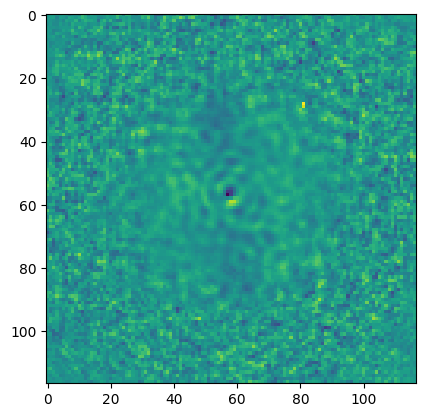

In [116]:
plt.imshow(residual_before_fine_tuning)

# Fine-tune the model

In [114]:
s4_model.fine_tune_model(
    num_epochs=100,
    learning_rate_planet=1e-3,
    learning_rate_noise=1e-6,
    fine_tune_noise_model=True,
    lean_planet_model=False,
    rotation_grid_down_sample=10,
    upload_rotation_grid=True,
    batch_size=-1)

  0%|          | 0/100 [00:00<?, ?it/s]

# Load the raw model again

In [117]:
s4_model_raw = S4(
    data_cube=science_data,
    parang=raw_angles,
    psf_template=psf_template_data,
    noise_noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_lambda_init=reg_lambda,
    noise_normalization="normal",
    planet_convolve_second=True,
    planet_use_up_sample=1,
    work_dir=s4_work_dir,
    verbose=True)

Creating right reason mask ... [DONE]


In [118]:
s4_noise_raw = S4Noise.load(saved_model)
s4_model_raw.noise_model = s4_noise_raw.float()

Creating right reason mask ... [DONE]


# Compute the loss terms

In [119]:
def compute_noise_estimate(model_in):
    # get all the data
    x_train = torch.from_numpy(model_in.data_cube).float()
    x_mu = torch.mean(x_train, axis=0)
    x_std = torch.std(x_train, axis=0)
    x_norm = (x_train - x_mu) / x_std
    
    # run the forward pass
    science_norm_flatten = x_norm.view(x_norm.shape[0], -1)
    model_in.noise_model.compute_betas()
    noise_estimate = model_in.noise_model(science_norm_flatten)
    
    return x_norm.view(-1, 117, 117).detach().numpy(), noise_estimate.view(-1, 117, 117).detach().numpy()

In [120]:
data_raw, noise_raw = compute_noise_estimate(s4_model_raw)
data_fine_tuned, noise_fine_tuned = compute_noise_estimate(s4_model)

## The loss terms

In [121]:
np.sum((data_raw - noise_raw)**2)

376152500.0

In [122]:
np.sum((data_fine_tuned - noise_fine_tuned)**2)

376102270.0

In [123]:
np.sum((s4_model_raw.noise_model.betas_raw **2).detach().numpy())

8281.342

In [124]:
np.sum((s4_model.noise_model.betas_raw **2).detach().numpy())

8281.322

In [125]:
errors_raw = np.mean((data_raw - noise_raw)**2, axis=(1, 2))
errors_fine_tuned = np.mean((data_raw - noise_fine_tuned)**2, axis=(1, 2))

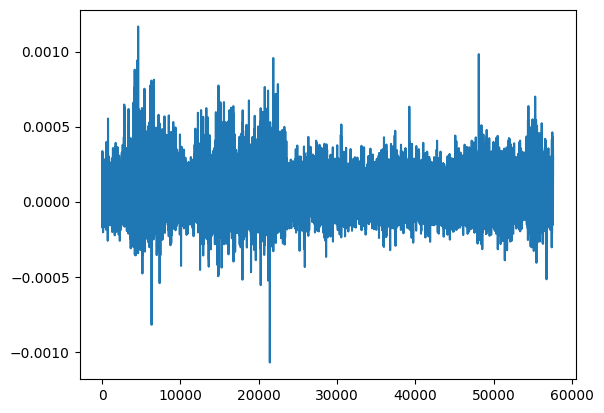

In [126]:
plt.plot(errors_raw - errors_fine_tuned)

In [127]:
beta_difference = s4_model.noise_model.betas - s4_model_raw.noise_model.betas

In [128]:
most_changed_region = torch.mean(torch.abs(beta_difference), axis=0).reshape(117, 117)

(-0.5, 116.5, 116.5, -0.5)

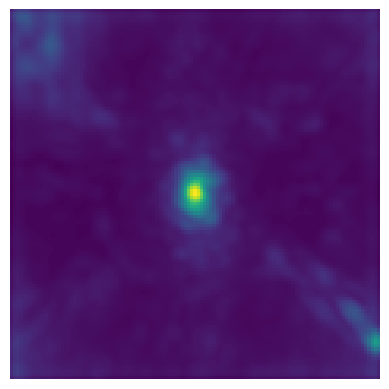

In [129]:
plt.imshow(most_changed_region.detach().numpy())
plt.axis("off")